In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
#from owslib.wfs import WebFeatureService
import geopandas as gpd
#import h5py 
import rasterio
import rasterio.mask
import glob2
from datetime import date
import re

In [2]:
def get_country_shapefile(path='../', country='Uganda', admin_level=1):
    """
    get shapefile of given country
    """
    country_shapefile = {
            'Uganda': 'uga_admbnda_adm'+str(admin_level)+'_UBOS_v2.shp'
            }
    return  gpd.read_file(str(path+'shapefiles/'+country+'/'+country_shapefile[country]))

In [3]:
gdf_country = get_country_shapefile()

# Example

In [4]:
shape = gdf_country.geometry.iloc[0]
district = gdf_country.ADM1_EN.iloc[0]

ABIM


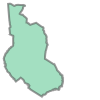

In [5]:
print(district)
shape

In [6]:
image_filename = '../../DMP_data/DMP_201201100000_GLOBE_VGT_V2.0.1/c_gls_DMP_QL_201201100000_GLOBE_VGT_V2.0.1.tiff'

with rasterio.open(image_filename, 'r') as src:
    # --- acces the image (the matrix with intensity values) ----
    img = src.read(1)

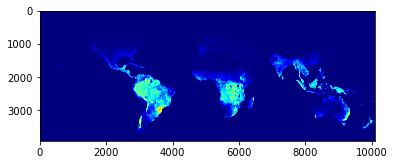

In [7]:
plt.imshow(img, cmap='jet');

In [8]:
with rasterio.open(image_filename, 'r') as src:
    output, out_transform = rasterio.mask.mask(src, [shape], crop=True)
out_img = output[0, :, :]

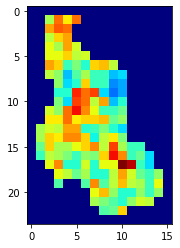

In [9]:
plt.imshow(out_img, cmap='jet');

In [10]:
np.sum(out_img)

3760

# Data Extraction

In [11]:
def decode_date(image_name):
    date_string = list(filter(lambda x: len(x)>7,re.findall('[0-9]+',image_name)))[0]
    year = int(date_string[0:4])
    month = int(date_string[4:6])
    day = int(date_string[6:8])
    return date(year,month,day)

In [12]:
def extract_zonal_stats(image_list,shape):

    zonal_stats = pd.DataFrame()

    values = []
    dates = []

    for image_path in image_list:

        image_name = image_path.split('\\')[-1]

        with rasterio.open(image_path, 'r') as src:
            output, out_transform = rasterio.mask.mask(src, [shape], crop=True)
        out_img = output[0, :, :]

        value =np.sum(out_img)

        collection_date = decode_date(image_name)

        values.append(value)

        dates.append(collection_date)

    zonal_stats['dates'] = dates
    zonal_stats['DMP'] = values
    zonal_stats.dates = pd.to_datetime(zonal_stats.dates,infer_datetime_format=True)
    zonal_stats.sort_values('dates',inplace=True)
    zonal_stats['year'] = zonal_stats.dates.dt.year
    zonal_stats['month'] = zonal_stats.dates.dt.month
    
    return zonal_stats

In [13]:
path_to_DMPdata = '..\\..\\DMP_data\\'
image_list = glob2.glob(path_to_DMPdata+'*\\*.tiff')

In [14]:
data = pd.DataFrame()

for (district, shape) in zip(gdf_country.ADM1_EN,gdf_country.geometry):
    
    zonal_stats = extract_zonal_stats(image_list,shape)
    temp = zonal_stats.groupby(['year','month']).sum().reset_index()
    temp['district'] = district
    data = pd.concat([data,temp])

In [19]:
data['date'] = data.apply(lambda x: date(x.year,x.month,1),axis=1)
data.sort_values('date',inplace=True)
data.reset_index(drop=True,inplace=True)
data = data[['date','year','month','district','DMP']]
data.head()

,date,year,month,district,DMP
0,2012-01-01,2012,1,ABIM,9746
1,2012-01-01,2012,1,KIBOGA,16634
2,2012-01-01,2012,1,BUDUDA,5376
3,2012-01-01,2012,1,NAMUTUMBA,7488
4,2012-01-01,2012,1,NAMISINDWA,4397


In [20]:
output_filemname = 'datasets/Uganda_DMP_data.csv'
data.to_csv(output_filemname, index=False)

# Example Timeseries

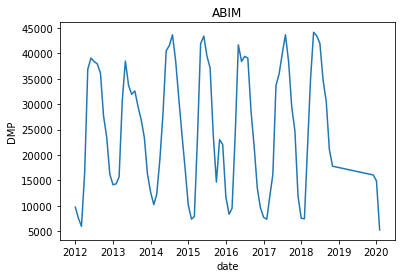

In [31]:
district = 'ABIM'
data[data.district==district][['date','DMP']].set_index('date').plot(legend=False)
plt.title(district)
plt.ylabel('DMP');